# Segmentacion de usuarios con aprendizaje no supervisado
En este notebook implementamos K-Means, DBSCAN, PCA y t-SNE sobre `citaschallenge`.
Aqui documentamos como analizamos los datos, ajustamos hiperparametros, comparamos métodos y resumimos los perfiles.


In [38]:
# Preparamos el entorno de trabajo para todo el flujo.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

RANDOM_STATE = 42
RESULTS_DIR = Path('../Results')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')


## 1) Como cargamos el dataset y revisamos su estructura


In [39]:
df = pd.read_excel('../Dataset/citaschallenge.xlsx')

print(df.head())
print(df.info())
print(df.describe(include='all'))


     GENERO  EDAD         ESPECIALIDAD TIPO_AFILIACION          FECHA_CITA  \
0  FEMENINO  41.0           ORTODONCIA            GOLD 2013-07-02 06:30:00   
1  FEMENINO  49.0  TERAPIA OCUPACIONAL          SILVER 2013-07-02 06:30:00   
2  FEMENINO  41.0         FISIOTERAPIA            GOLD 2013-07-02 06:30:00   
3  FEMENINO  49.0         FISIOTERAPIA            GOLD 2013-07-02 06:50:00   
4  FEMENINO  36.0           RADIOLOGIA            GOLD 2013-07-02 06:50:00   

      id  ESTAFINAL  
0   9373          3  
1  62884          2  
2  72568          2  
3   5733          1  
4  22397          3  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67650 entries, 0 to 67649
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   GENERO           67650 non-null  object        
 1   EDAD             67650 non-null  float64       
 2   ESPECIALIDAD     67650 non-null  object        
 3   TIPO_AFILIACION  6765

## 2) Como limpiamos y transformamos las variables


In [40]:
print('Valores nulos por columna:')
print(df.isnull().sum())

print()
print(f'Cantidad de filas duplicadas: {df.duplicated().sum()}')

# Definimos mapeos para transformar variables categoricas a numericas.
gender_map = {'FEMENINO': 0, 'MASCULINO': 1}
affiliation_map = {'CONVENIO': 1, 'SILVER': 2, 'GOLD': 3}

df['GENERO'] = df['GENERO'].str.upper().map(gender_map)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].str.upper().map(affiliation_map)

if df['GENERO'].isnull().any():
    faltantes = sorted(df.loc[df['GENERO'].isnull(), 'GENERO'].astype(str).unique())
    raise ValueError(f'Valores inesperados en GENERO tras mapeo: {faltantes}')

if df['TIPO_AFILIACION'].isnull().any():
    faltantes = sorted(df.loc[df['TIPO_AFILIACION'].isnull(), 'TIPO_AFILIACION'].astype(str).unique())
    raise ValueError(f'Valores inesperados en TIPO_AFILIACION tras mapeo: {faltantes}')

df['GENERO'] = df['GENERO'].astype(int)
df['EDAD'] = df['EDAD'].astype(int)
df['TIPO_AFILIACION'] = df['TIPO_AFILIACION'].astype(int)

print()
print('Tipos de datos luego de limpieza:')
print(df.dtypes)


Valores nulos por columna:
GENERO             0
EDAD               0
ESPECIALIDAD       0
TIPO_AFILIACION    0
FECHA_CITA         0
id                 0
ESTAFINAL          0
dtype: int64

Cantidad de filas duplicadas: 0

Tipos de datos luego de limpieza:
GENERO                      int64
EDAD                        int64
ESPECIALIDAD               object
TIPO_AFILIACION             int64
FECHA_CITA         datetime64[ns]
id                          int64
ESTAFINAL                   int64
dtype: object


## 3) Como exploramos los datos con visualizaciones


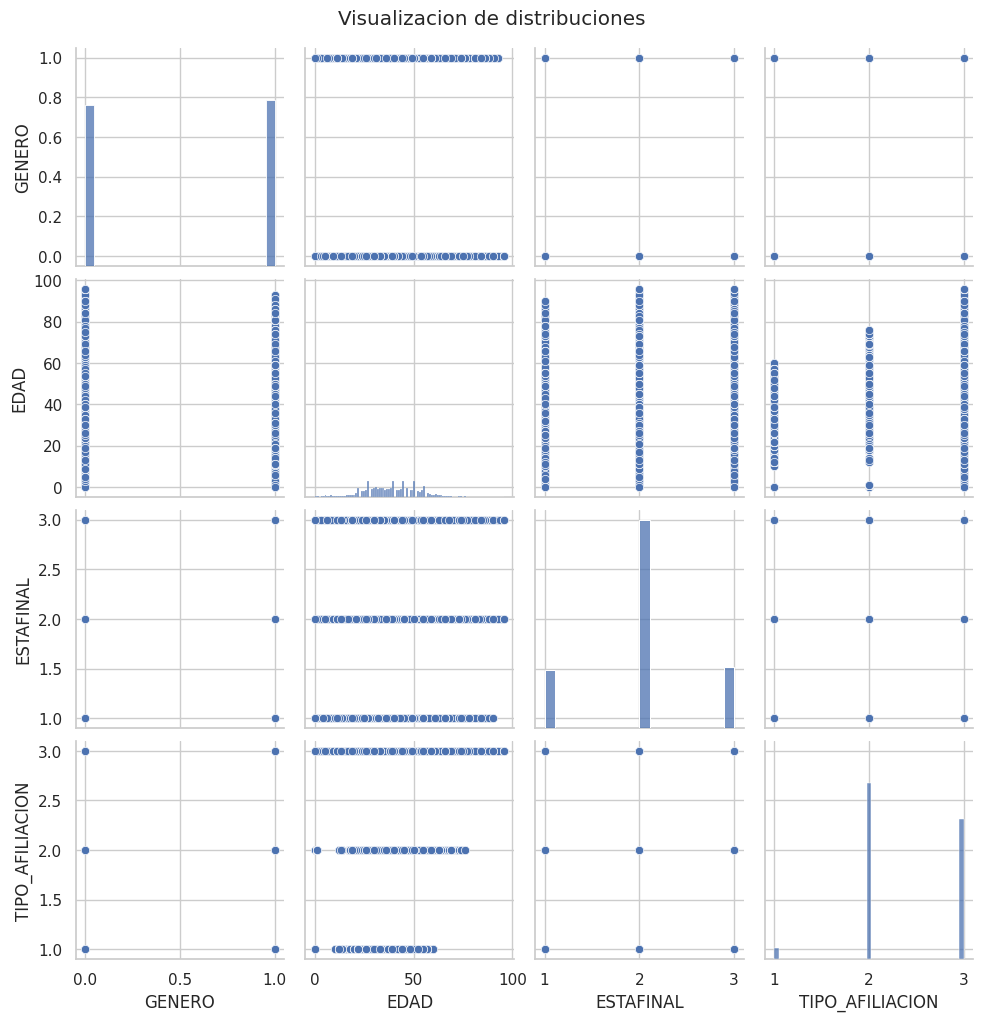

In [41]:
pairplot = sns.pairplot(df[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']])
pairplot.fig.suptitle('Visualizacion de distribuciones', y=1.02)
pairplot.fig.savefig(RESULTS_DIR / 'visualizacion_distribuciones.png', dpi=150, bbox_inches='tight')
plt.show()


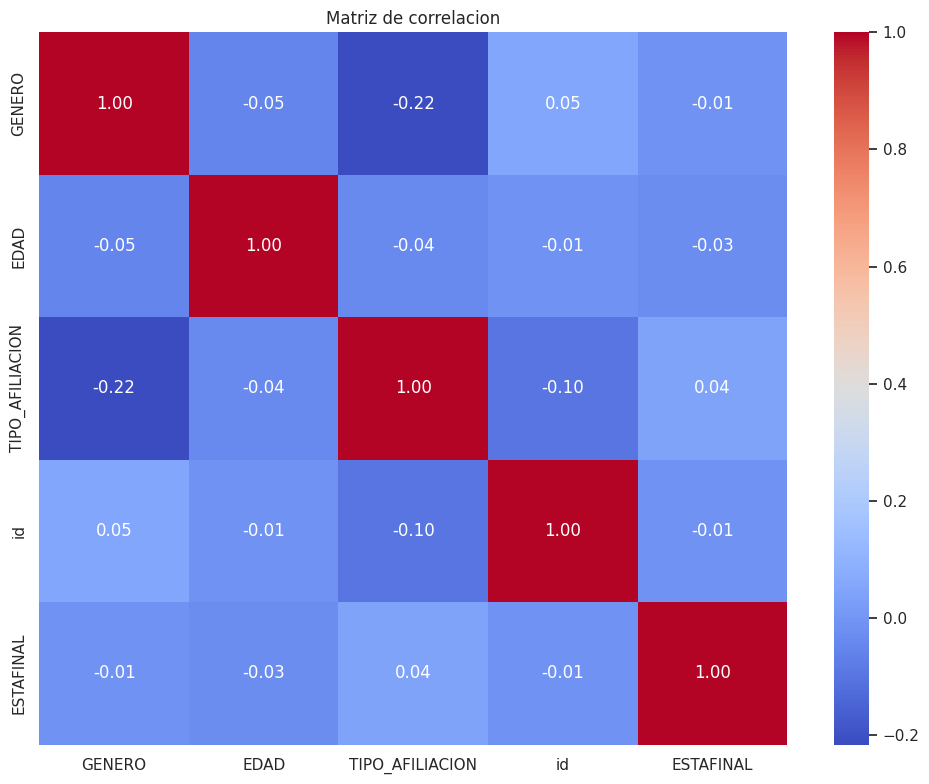

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlacion')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'matriz_correlacion.png', dpi=150)
plt.show()


## 4) Como preparamos los datos para el modelado


In [43]:
X = df[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 5) Como ajustamos K-Means y segmentamos perfiles


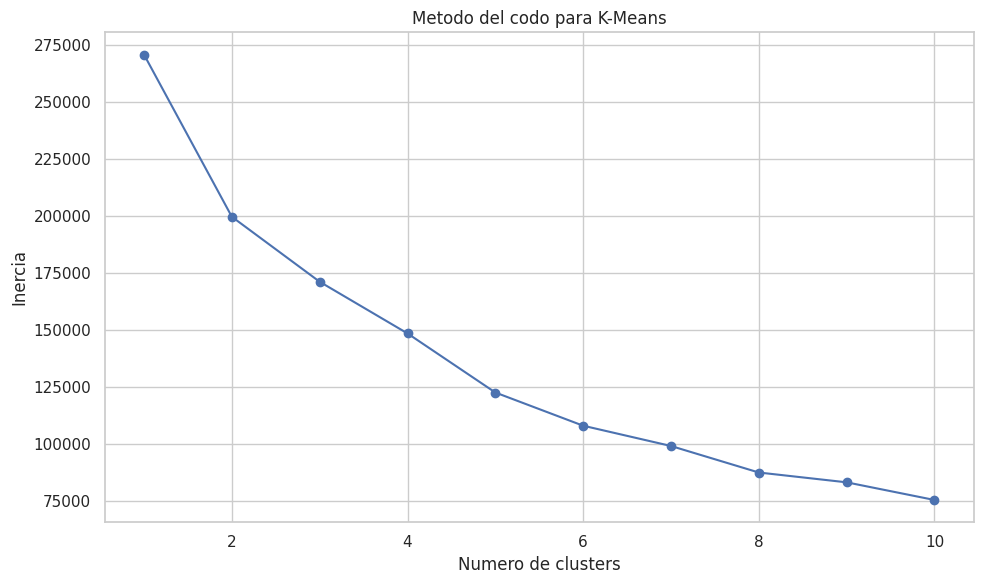

Para k=2, el silhouette score es: 0.3017
Para k=3, el silhouette score es: 0.3151
Para k=4, el silhouette score es: 0.3437
Para k=5, el silhouette score es: 0.3695
Para k=6, el silhouette score es: 0.3850


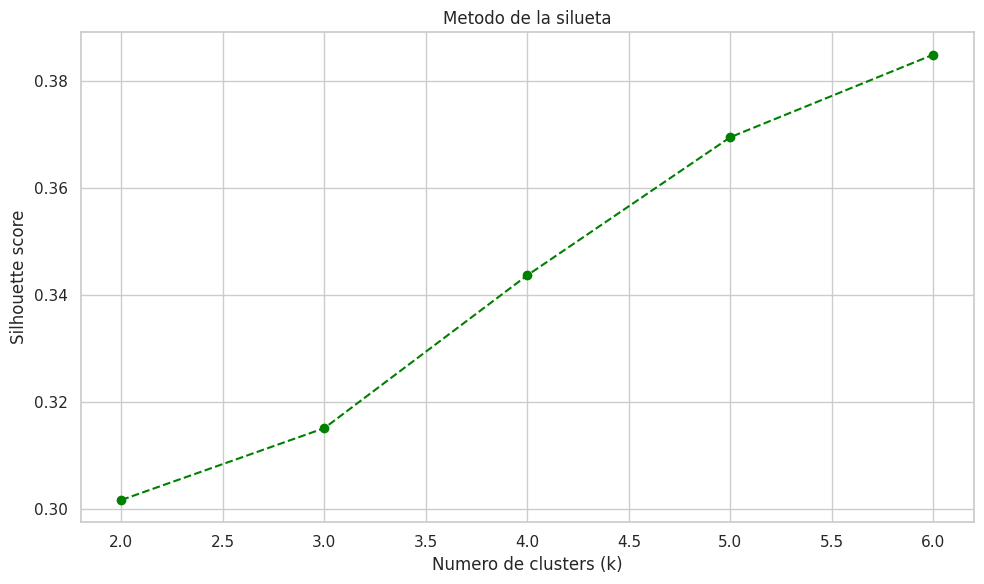

In [44]:
# Evaluamos la inercia para identificar un rango razonable de K.
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, n_init='auto', random_state=RANDOM_STATE)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Numero de clusters')
plt.ylabel('Inercia')
plt.title('Metodo del codo para K-Means')
plt.grid(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'metodo_codo.png', dpi=150)
plt.show()

# Complementamos la seleccion de K usando silhouette score.
X_sample = X_scaled[:10000]
silhouette_scores = []
k_range = range(2, 7)
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    silhouette_scores.append(score)
    print(f'Para k={k}, el silhouette score es: {score:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Metodo de la silueta')
plt.xlabel('Numero de clusters (k)')
plt.ylabel('Silhouette score')
plt.grid(True)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'metodo_silueta.png', dpi=150)
plt.show()


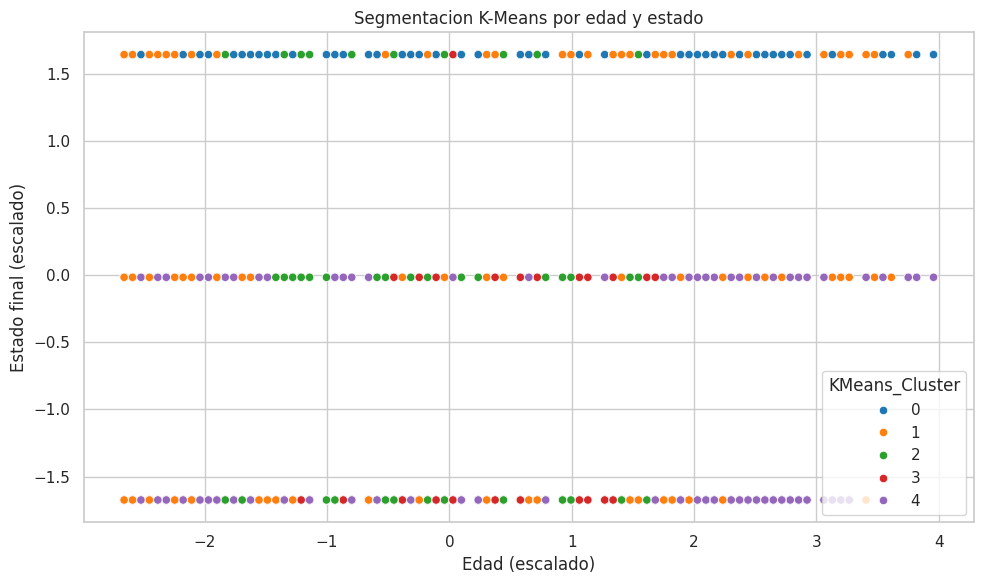

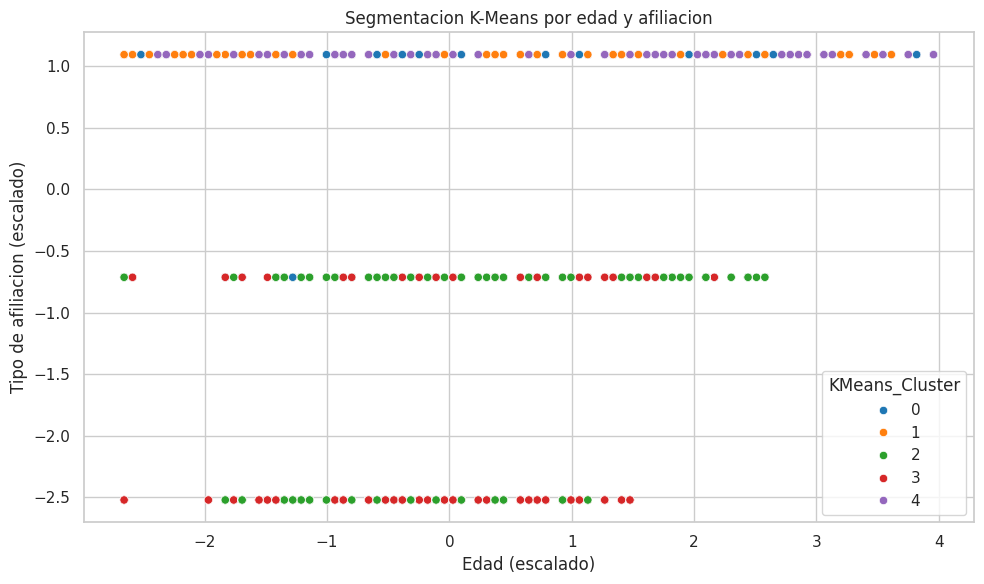

In [45]:
# Entrenamos el modelo final de K-Means con k=5.
kmeans = KMeans(n_clusters=5, n_init='auto', random_state=RANDOM_STATE)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['KMeans_Cluster'], palette='tab10')
plt.xlabel('Edad (escalado)')
plt.ylabel('Estado final (escalado)')
plt.title('Segmentacion K-Means por edad y estado')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_kmeans_edad.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 3], hue=df['KMeans_Cluster'], palette='tab10')
plt.xlabel('Edad (escalado)')
plt.ylabel('Tipo de afiliacion (escalado)')
plt.title('Segmentacion K-Means por edad y afiliacion')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_kmeans_afiliacion.png', dpi=150)
plt.show()


In [46]:
kmeans_summary = df.groupby('KMeans_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].mean().round(3)
display(kmeans_summary)
kmeans_summary.to_csv(RESULTS_DIR / 'resumen_clusters_kmeans.csv')


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.419,3.000,2.723
1,1.0,36.655,2.046,3.000
2,1.0,38.355,1.986,1.965
3,0.0,41.398,1.832,1.889
4,0.0,38.366,1.699,3.000


## 6) Como ajustamos DBSCAN y comparamos segmentaciones


,eps,min_samples,n_clusters,noise_ratio,silhouette
3,0.3,30,16,0.0359,0.499682
7,0.5,30,15,0.0143,0.496314
6,0.5,20,16,0.0098,0.495867
11,0.7,30,15,0.0116,0.494501
1,0.3,10,19,0.0067,0.494409
10,0.7,20,16,0.0064,0.493870
15,0.9,30,16,0.0052,0.493131
14,0.9,20,16,0.0050,0.493065
19,1.1,30,16,0.0050,0.493065
5,0.5,10,18,0.0029,0.493011


Parametros seleccionados DBSCAN -> eps=0.3, min_samples=30


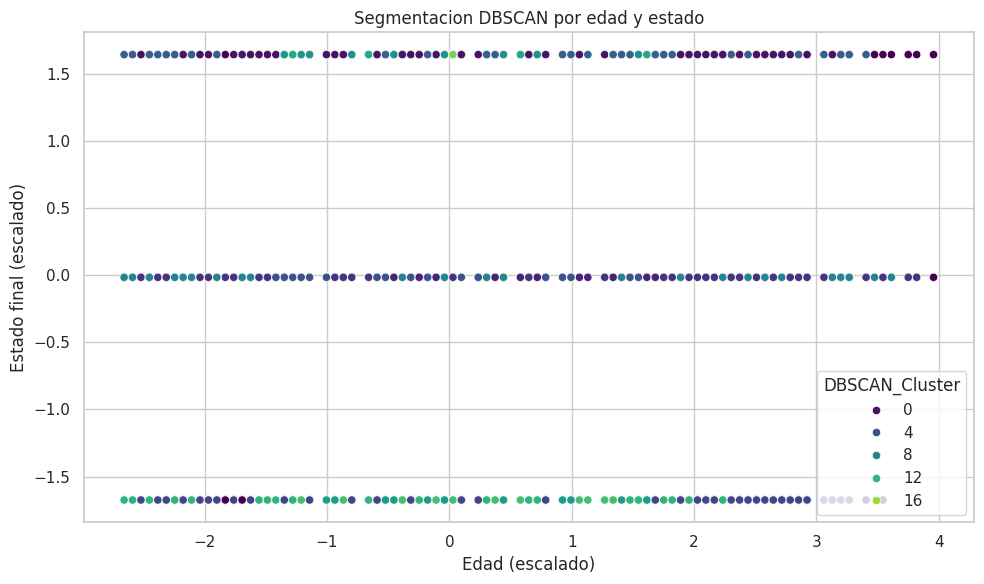

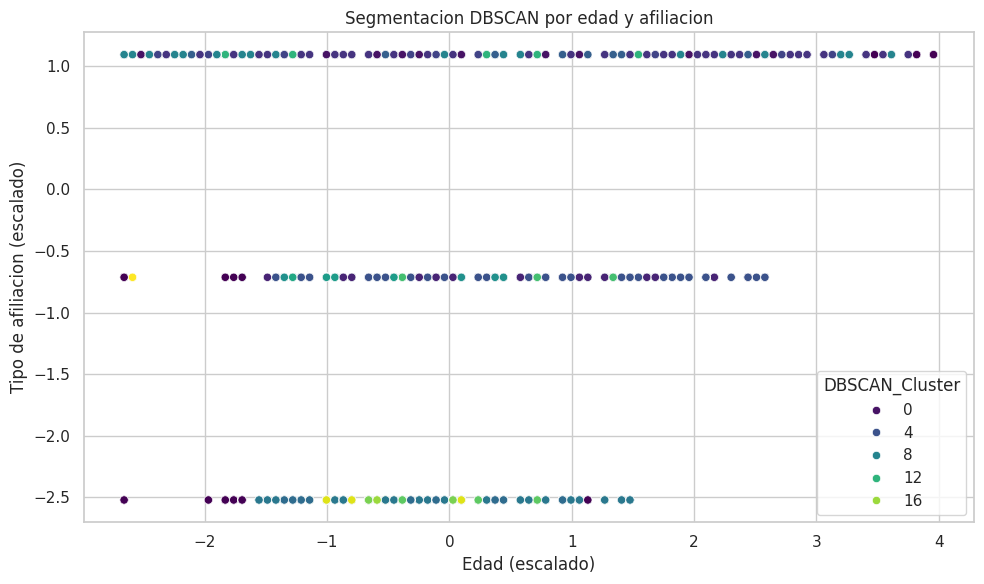

In [47]:
# Buscamos hiperparametros de DBSCAN con una grilla simple.
search_sample = X_scaled[:10000]
search_rows = []

for eps in [0.3, 0.5, 0.7, 0.9, 1.1, 1.3]:
    for min_samples in [5, 10, 20, 30]:
        labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(search_sample)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        noise_ratio = float((labels == -1).mean())

        score = np.nan
        valid_mask = labels != -1
        if n_clusters > 1 and valid_mask.sum() > 1 and len(set(labels[valid_mask])) > 1:
            score = silhouette_score(search_sample[valid_mask], labels[valid_mask])

        search_rows.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'silhouette': score,
        })

dbscan_search = pd.DataFrame(search_rows).sort_values(
    ['silhouette', 'noise_ratio', 'n_clusters'],
    ascending=[False, True, False],
    na_position='last'
)

display(dbscan_search.head(10))
dbscan_search.to_csv(RESULTS_DIR / 'dbscan_busqueda_parametros.csv', index=False)

if dbscan_search['silhouette'].notna().any():
    best_row = dbscan_search[dbscan_search['silhouette'].notna()].iloc[0]
else:
    best_row = dbscan_search.sort_values(['n_clusters', 'noise_ratio'], ascending=[False, True]).iloc[0]

best_eps = float(best_row['eps'])
best_min_samples = int(best_row['min_samples'])
print(f'Parametros seleccionados DBSCAN -> eps={best_eps}, min_samples={best_min_samples}')

# Entrenamos DBSCAN final con los parametros seleccionados.
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='viridis')
plt.xlabel('Edad (escalado)')
plt.ylabel('Estado final (escalado)')
plt.title('Segmentacion DBSCAN por edad y estado')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_dbscan_edad.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 3], hue=df['DBSCAN_Cluster'], palette='viridis')
plt.xlabel('Edad (escalado)')
plt.ylabel('Tipo de afiliacion (escalado)')
plt.title('Segmentacion DBSCAN por edad y afiliacion')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'segmentacion_dbscan_afiliacion.png', dpi=150)
plt.show()


In [48]:
display(df['DBSCAN_Cluster'].value_counts().sort_index())

dbscan_summary = df.groupby('DBSCAN_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].mean().round(3)
display(dbscan_summary)
dbscan_summary.to_csv(RESULTS_DIR / 'resumen_clusters_dbscan.csv')


DBSCAN_Cluster
-1       121
 0      4931
 1      9187
 2      9566
 3      4119
 4     16971
 5      2523
 6       544
 7       915
 8      5777
 9      2888
 10     3260
 11     1884
 12     2023
 13     2138
 14      247
 15      233
 16      154
 17       31
 18       99
 19       39
Name: count, dtype: int64

,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
DBSCAN_Cluster,,,,
-1,0.628,35.545,1.909,1.504
0,0.000,36.207,3.000,3.000
1,0.000,42.680,2.000,2.000
2,0.000,38.447,2.000,3.000
3,0.000,38.124,1.000,3.000
4,1.000,39.224,2.000,2.000
5,1.000,35.579,3.000,3.000
6,1.000,32.114,2.000,1.000
7,0.000,34.375,2.000,1.000


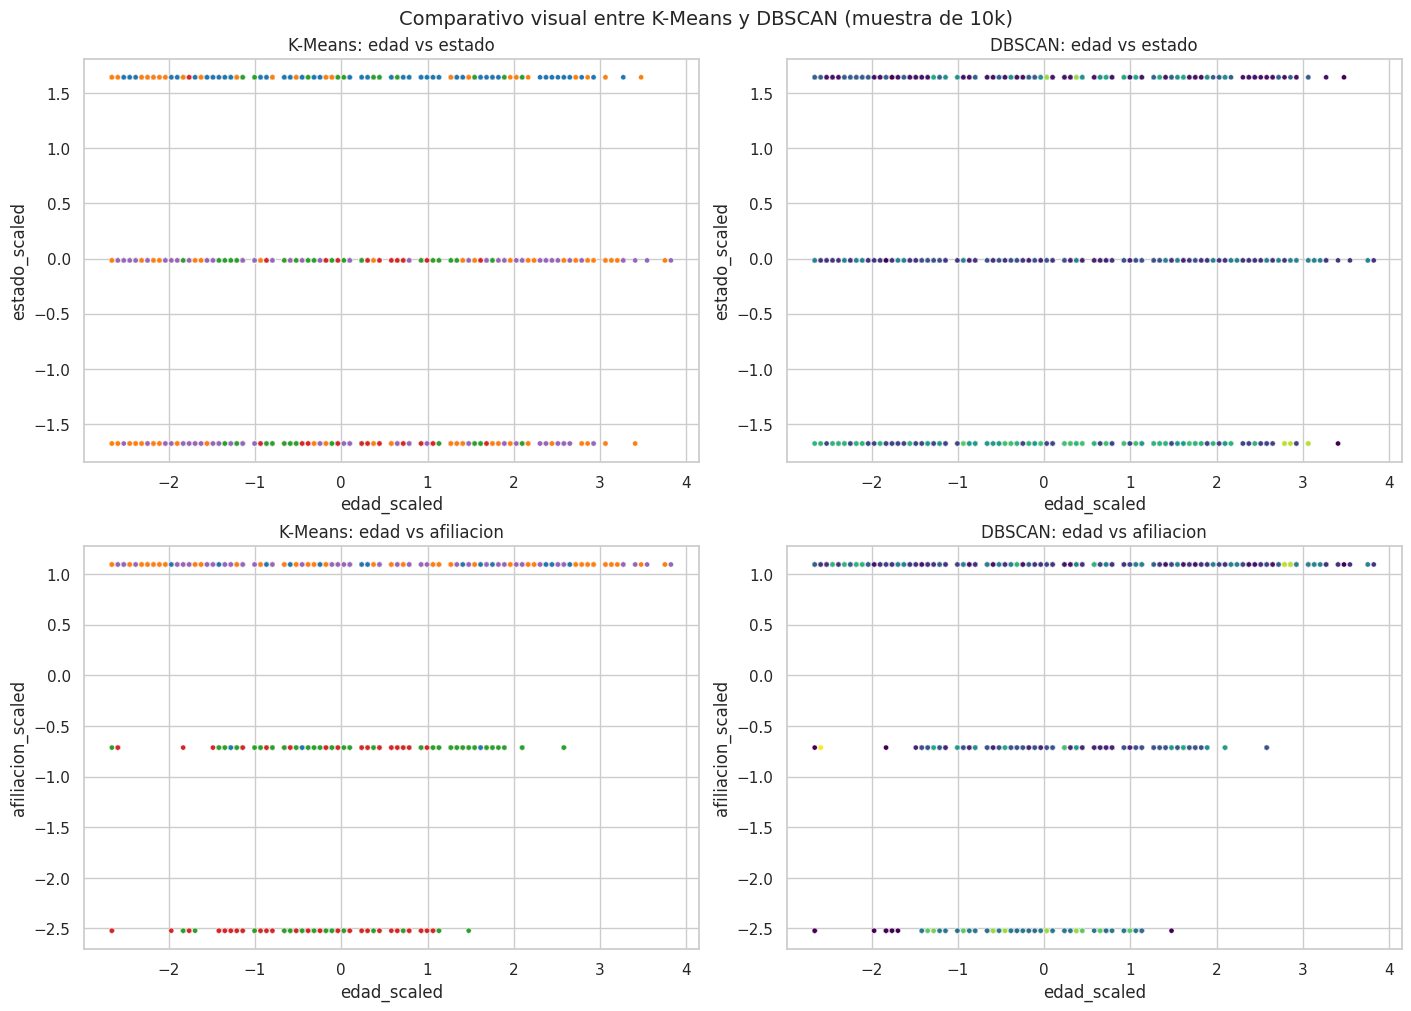

In [49]:
plot_size = min(len(X_scaled), 10000)
plot_idx = np.random.default_rng(RANDOM_STATE).choice(len(X_scaled), size=plot_size, replace=False)

comp_df = pd.DataFrame({
    'edad_scaled': X_scaled[plot_idx, 1],
    'estado_scaled': X_scaled[plot_idx, 2],
    'afiliacion_scaled': X_scaled[plot_idx, 3],
    'kmeans': df['KMeans_Cluster'].to_numpy()[plot_idx],
    'dbscan': df['DBSCAN_Cluster'].to_numpy()[plot_idx],
})

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)

sns.scatterplot(data=comp_df, x='edad_scaled', y='estado_scaled', hue='kmeans', palette='tab10', s=14, ax=axes[0, 0], legend=False)
axes[0, 0].set_title('K-Means: edad vs estado')

sns.scatterplot(data=comp_df, x='edad_scaled', y='estado_scaled', hue='dbscan', palette='viridis', s=14, ax=axes[0, 1], legend=False)
axes[0, 1].set_title('DBSCAN: edad vs estado')

sns.scatterplot(data=comp_df, x='edad_scaled', y='afiliacion_scaled', hue='kmeans', palette='tab10', s=14, ax=axes[1, 0], legend=False)
axes[1, 0].set_title('K-Means: edad vs afiliacion')

sns.scatterplot(data=comp_df, x='edad_scaled', y='afiliacion_scaled', hue='dbscan', palette='viridis', s=14, ax=axes[1, 1], legend=False)
axes[1, 1].set_title('DBSCAN: edad vs afiliacion')

fig.suptitle('Comparativo visual entre K-Means y DBSCAN (muestra de 10k)', fontsize=14)
plt.savefig(RESULTS_DIR / 'comparativo_kmeans_dbscan.png', dpi=150)
plt.show()


In [50]:
df_no_noise = df[df['DBSCAN_Cluster'] != -1]

dbscan_no_noise_summary = df_no_noise.groupby('DBSCAN_Cluster')[['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].mean().round(3)
display(dbscan_no_noise_summary)
dbscan_no_noise_summary.to_csv(RESULTS_DIR / 'resumen_clusters_dbscan_sin_ruido.csv')


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
DBSCAN_Cluster,,,,
0,0.0,36.207,3.0,3.0
1,0.0,42.680,2.0,2.0
2,0.0,38.447,2.0,3.0
3,0.0,38.124,1.0,3.0
4,1.0,39.224,2.0,2.0
5,1.0,35.579,3.0,3.0
6,1.0,32.114,2.0,1.0
7,0.0,34.375,2.0,1.0
8,1.0,37.783,2.0,3.0


## 7) Como reducimos dimensionalidad con PCA y t-SNE


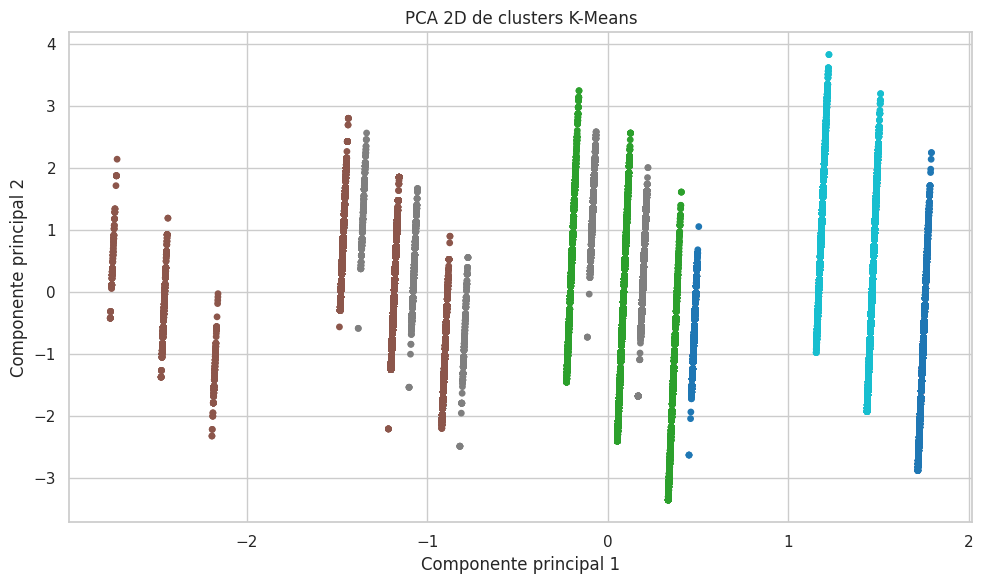

In [51]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='tab10', s=15)
plt.title('PCA 2D de clusters K-Means')
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'pca_kmeans.png', dpi=150)
plt.show()


In [52]:
display(kmeans_summary)


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.419,3.000,2.723
1,1.0,36.655,2.046,3.000
2,1.0,38.355,1.986,1.965
3,0.0,41.398,1.832,1.889
4,0.0,38.366,1.699,3.000


In [53]:
for cluster_id in sorted(df['KMeans_Cluster'].unique()):
    print()
    print(f'Cluster {cluster_id}')
    display(df[df['KMeans_Cluster'] == cluster_id][['GENERO', 'EDAD', 'ESTAFINAL', 'TIPO_AFILIACION']].head())



Cluster 0


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
0,0,40,3,3
4,0,36,3,3
5,0,39,3,3
10,0,8,3,3
18,0,31,3,3



Cluster 1


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
13,1,37,3,3
17,1,55,2,3
26,1,45,2,3
73,1,30,2,3
81,1,60,3,3



Cluster 2


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
9,1,50,2,2
12,1,27,2,2
14,1,45,2,1
20,1,29,2,2
22,1,25,3,2



Cluster 3


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
1,0,49,2,2
8,0,31,2,2
15,0,45,2,1
19,0,48,2,2
21,0,50,2,2



Cluster 4


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
2,0,40,2,3
3,0,49,1,3
6,0,55,1,3
7,0,32,2,3
11,0,45,1,3


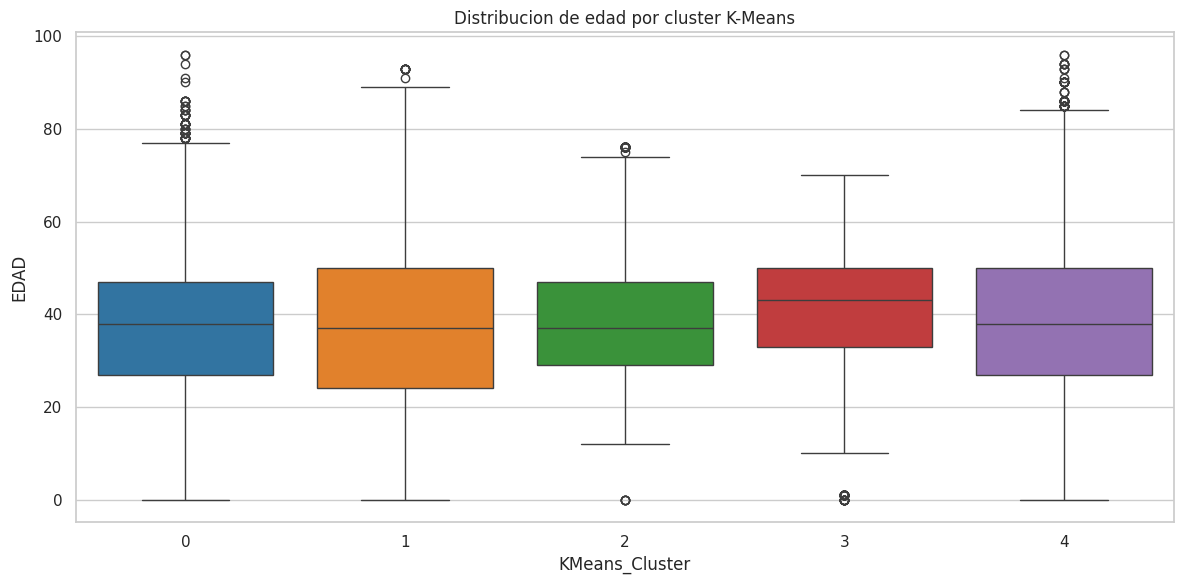

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='KMeans_Cluster',
    y='EDAD',
    hue='KMeans_Cluster',
    data=df,
    palette='tab10',
    legend=False
)
plt.title('Distribucion de edad por cluster K-Means')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tiempo_uso_cluster.png', dpi=150)
plt.show()


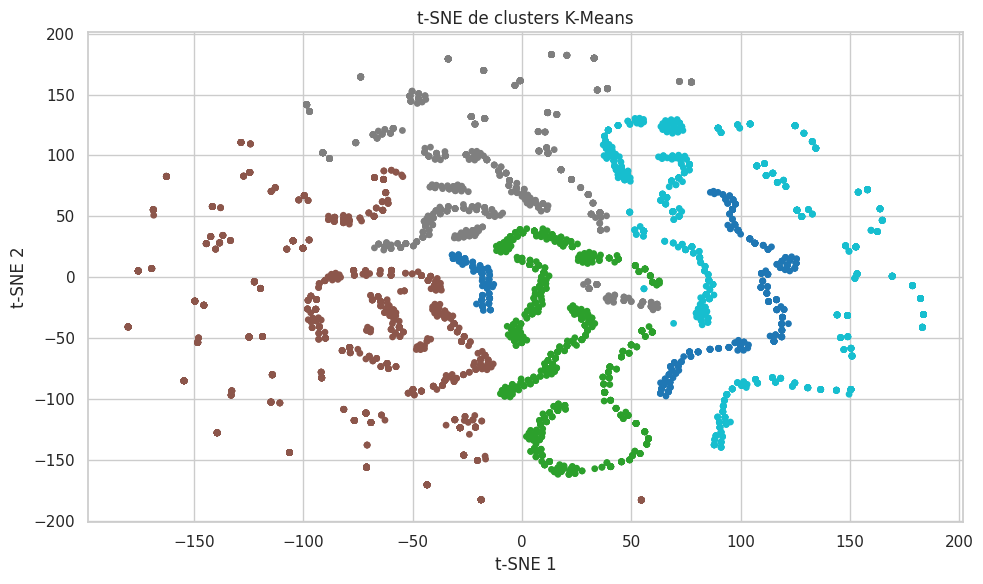

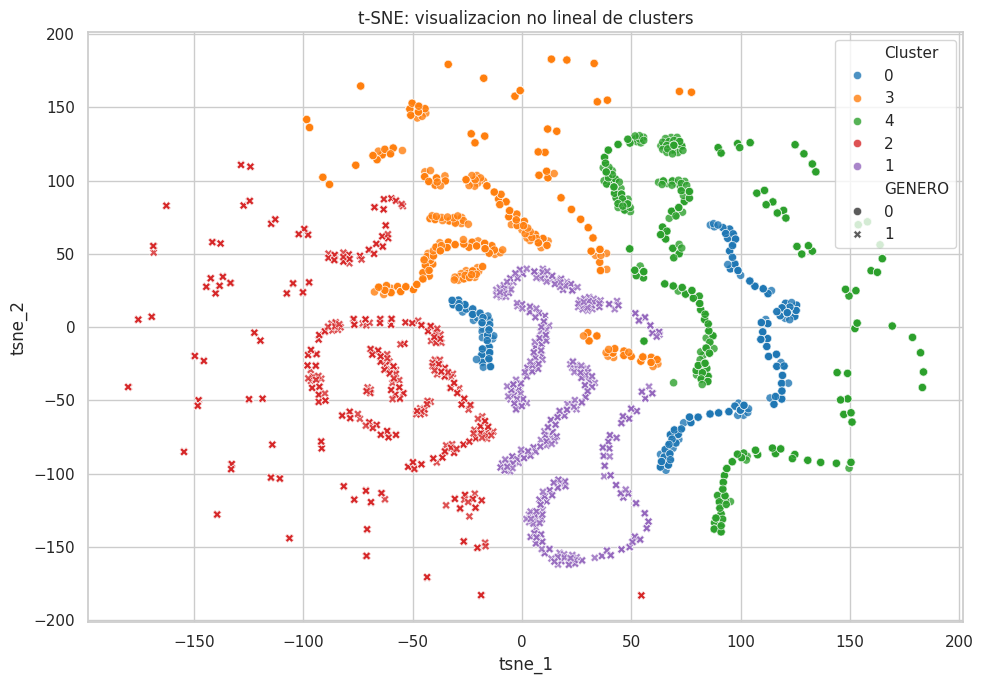

In [55]:
# Limitamos la muestra para que t-SNE sea ejecutable en hardware comun.
sample_size = min(len(X_scaled), 5000)
X_tsne_input = X_scaled[:sample_size]
labels_tsne = df['KMeans_Cluster'].iloc[:sample_size].to_numpy()
gender_tsne = df['GENERO'].iloc[:sample_size].to_numpy()

tsne = TSNE(
    n_components=2,
    method='barnes_hut',
    perplexity=30,
    learning_rate=200,
    random_state=RANDOM_STATE,
    init='pca'
)
X_tsne = tsne.fit_transform(X_tsne_input)

plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels_tsne, cmap='tab10', s=15)
plt.title('t-SNE de clusters K-Means')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_kmeans.png', dpi=150)
plt.show()

df_tsne = pd.DataFrame(X_tsne, columns=['tsne_1', 'tsne_2'])
df_tsne['Cluster'] = labels_tsne.astype(str)
df_tsne['GENERO'] = gender_tsne

plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_tsne,
    x='tsne_1',
    y='tsne_2',
    hue='Cluster',
    style='GENERO',
    palette='tab10',
    alpha=0.8,
    s=35
)
plt.title('t-SNE: visualizacion no lineal de clusters')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'tsne_genero.png', dpi=150)
plt.show()


## 8) Como cerramos el análisis y sintetizamos conclusiones técnicas


In [56]:
display(kmeans_summary)

print('Clusters unicos KMeans:', sorted(df['KMeans_Cluster'].unique()))
print('Clusters unicos DBSCAN:', sorted(df['DBSCAN_Cluster'].unique()))
print(f'Parametros finales DBSCAN: eps={best_eps}, min_samples={best_min_samples}')
print(f'Porcentaje de ruido DBSCAN: {(df["DBSCAN_Cluster"] == -1).mean():.2%}')


,GENERO,EDAD,ESTAFINAL,TIPO_AFILIACION
KMeans_Cluster,,,,
0,0.0,37.419,3.000,2.723
1,1.0,36.655,2.046,3.000
2,1.0,38.355,1.986,1.965
3,0.0,41.398,1.832,1.889
4,0.0,38.366,1.699,3.000


Clusters unicos KMeans: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4)]
Clusters unicos DBSCAN: [np.int64(-1), np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)]
Parametros finales DBSCAN: eps=0.3, min_samples=30
Porcentaje de ruido DBSCAN: 0.18%
